# Импортируем библиотеку

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import seaborn as sns
import matplotlib.pyplot as plt

2024-12-01 13:29:52.413879: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Настраиваем параметры

In [2]:
EMBEDDING_DIM = 2048
UNITS = 512
MAX_VOCAB_SIZE = 5000
MAX_LENGTH = 55
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)
N = 1000

In [3]:
CSV_PATH = "/home/sb/Downloads/Image-Captioning/flickr30k_images/results.csv"
IMAGE_DIR = "/home/sb/Downloads/Image-Captioning/flickr30k_images/flickr30k_images"

# Загружаем данные

In [4]:
df = pd.read_csv(CSV_PATH, delimiter="|").rename(columns={" comment": "comment"}).drop([' comment_number'], axis=1)[:N]
images = df['image_name'].values[:N]
captions = df['comment'].values[:N]
df

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
158910,998845445.jpg,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,A man is leaning off of the side of a blue an...
158913,998845445.jpg,"A man riding a small boat in a harbor , with ..."


# EDA

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158915 non-null  object
 1   comment     158914 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158914 entries, 0 to 158914
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  158914 non-null  object
 1   comment     158914 non-null  object
dtypes: object(2)
memory usage: 3.6+ MB


In [25]:
count_words = df['comment'].apply(lambda x: len(x.split()))
count_words

0         17
1         11
2         11
3         11
4          7
          ..
158910    25
158911    25
158912    23
158913    18
158914    17
Name: comment, Length: 158914, dtype: int64

In [26]:
count_simbols = df['comment'].apply(lambda x: len(x))
count_simbols

0          84
1          55
2          49
3          45
4          40
         ... 
158910    118
158911    106
158912     90
158913     83
158914     78
Name: comment, Length: 158914, dtype: int64

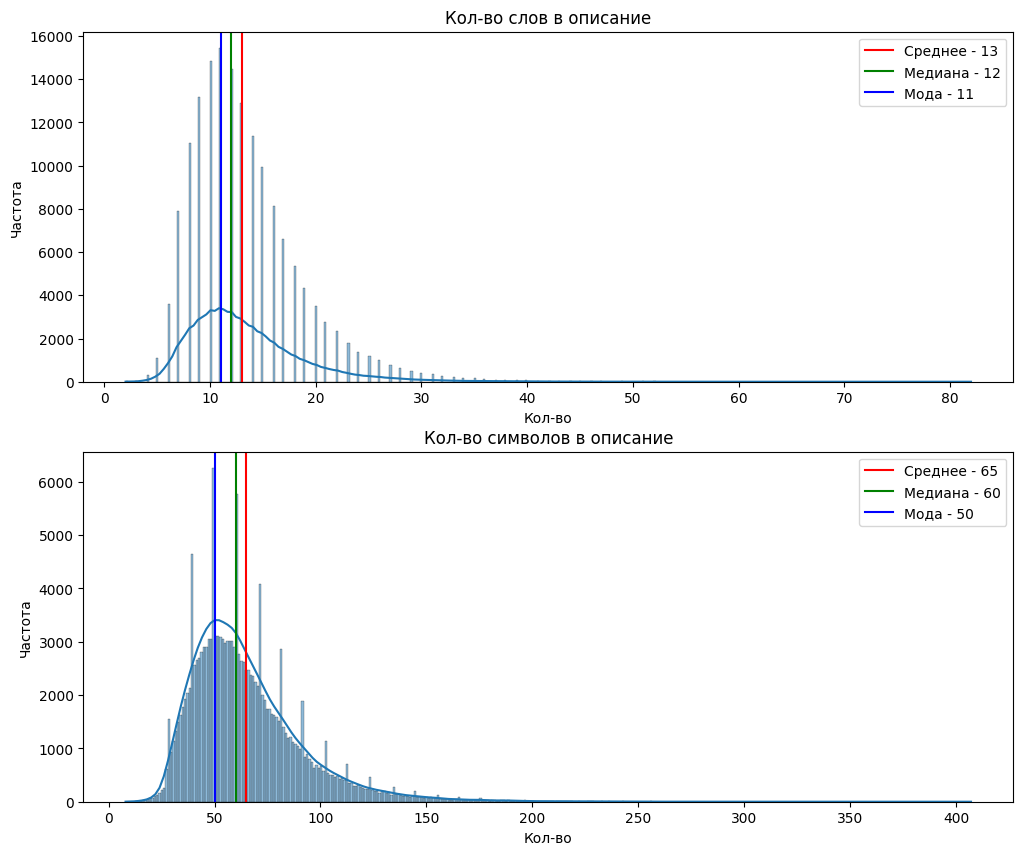

In [51]:
fig, axe = plt.subplots(2, 1, figsize=(12, 10))

mean1 = round(count_words.mean())
median1 = round(count_words.median())
mode1 = round(count_words.mode()[0])

mean2 = round(count_simbols.mean())
median2 = round(count_simbols.median())
mode2 = round(count_simbols.mode()[0])


sns.histplot(x=count_words, ax=axe[0], kde=True)

axe[0].axvline(mean1, c='r', label=f'Среднее - {mean1}')
axe[0].axvline(median1, c='g', label=f'Медиана - {median1}')
axe[0].axvline(mode1, c='b', label=f'Мода - {mode1}')

axe[0].set_title("Кол-во слов в описание")
axe[0].set_xlabel("Кол-во")
axe[0].set_ylabel("Частота")
axe[0].legend()

sns.histplot(x=count_simbols, ax=axe[1], kde=True)

axe[1].set_title("Кол-во символов в описание")
axe[1].set_xlabel("Кол-во")
axe[1].set_ylabel("Частота")

axe[1].axvline(mean2, c='r', label=f'Среднее - {mean2}')
axe[1].axvline(median2, c='g', label=f'Медиана - {median2}')
axe[1].axvline(mode2, c='b', label=f'Мода - {mode2}')
axe[1].legend()

plt.show()

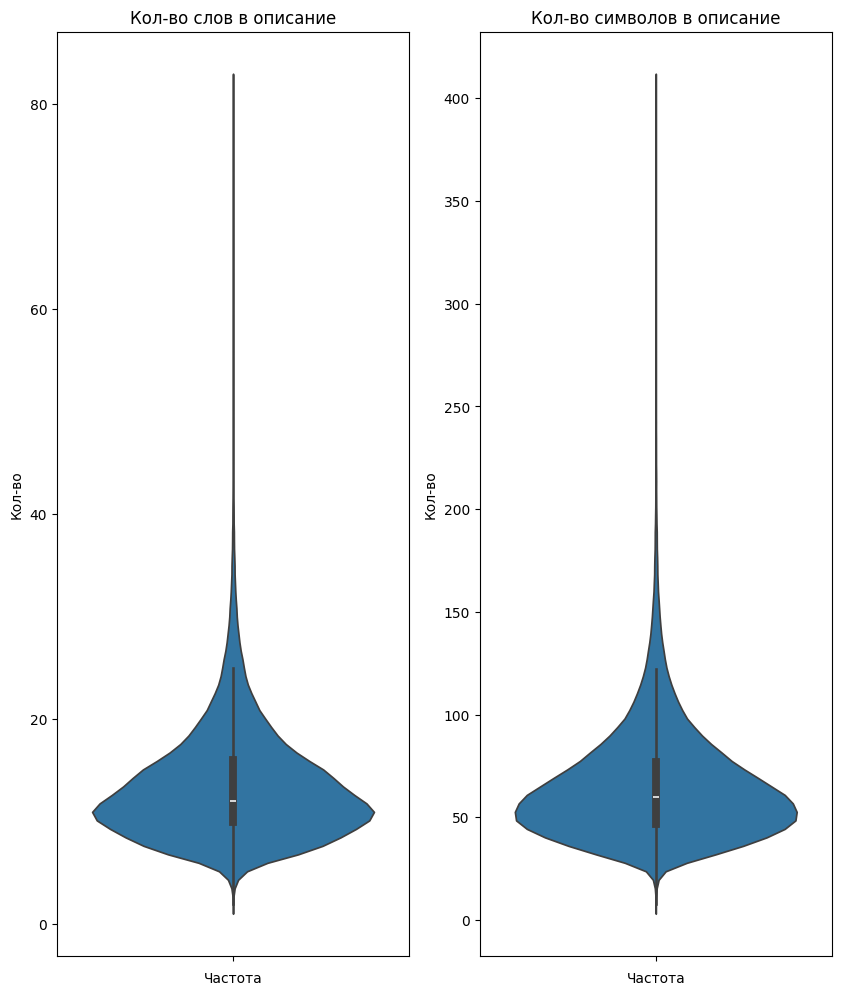

In [57]:
fig, axe = plt.subplots(1, 2, figsize=(10, 12))

sns.violinplot(y=count_words, ax=axe[0])

axe[0].set_title("Кол-во слов в описание")
axe[0].set_ylabel("Кол-во")
axe[0].set_xlabel("Частота")

sns.violinplot(y=count_simbols, ax=axe[1])

axe[1].set_title("Кол-во символов в описание")
axe[1].set_ylabel("Кол-во")
axe[1].set_xlabel("Частота")

plt.show()

In [6]:
def build_encoder():
    base_model = InceptionV3(weights='imagenet')
    base_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    for layer in base_model.layers:
        layer.trainable = False
    return base_model

encoder = build_encoder()

In [7]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return encoder.predict(img)

In [29]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_66858/1899435095.py:4: SyntaxWarning: invalid escape sequence '\s'
  data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))


In [31]:
data = text_preprocessing(df)
captions = data['comment'].tolist()
captions[:10]


['startseq startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq endseq',
 'startseq startseq two young white males are outside near many bushes endseq endseq',
 'startseq startseq two men in green shirts are standing in yard endseq endseq',
 'startseq startseq man in blue shirt standing in garden endseq endseq',
 'startseq startseq two friends enjoy time spent together endseq endseq',
 'startseq startseq several men in hard hats are operating giant pulley system endseq endseq',
 'startseq startseq workers look down from up above on piece of equipment endseq endseq',
 'startseq startseq two men working on machine wearing hard hats endseq endseq',
 'startseq startseq four men on top of tall structure endseq endseq',
 'startseq startseq three men on large rig endseq endseq']

In [9]:
# Токенизация текстов
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(captions)
sequences = tokenizer.texts_to_sequences(captions)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = min(MAX_VOCAB_SIZE, len(word_index)) + 1
index_word

{1: '<unk>',
 2: 'a',
 3: 'in',
 4: 'the',
 5: 'on',
 6: 'man',
 7: 'and',
 8: 'of',
 9: 'is',
 10: 'with',
 11: 'two',
 12: 'are',
 13: 'at',
 14: 'to',
 15: 'woman',
 16: 'an',
 17: 'people',
 18: 'shirt',
 19: 'wearing',
 20: 'black',
 21: 'sitting',
 22: 'white',
 23: 'young',
 24: 'dog',
 25: 'while',
 26: 'his',
 27: 'red',
 28: 'boy',
 29: 'men',
 30: 'blue',
 31: 'front',
 32: 'girl',
 33: 'street',
 34: 'standing',
 35: 'playing',
 36: 'green',
 37: 'group',
 38: 'little',
 39: 'her',
 40: 'outside',
 41: 'water',
 42: 'over',
 43: 'three',
 44: 'one',
 45: 'walking',
 46: 'by',
 47: 'person',
 48: 'down',
 49: 'from',
 50: 'child',
 51: 'next',
 52: 'through',
 53: 'snow',
 54: 'near',
 55: 'large',
 56: 'hat',
 57: 'holding',
 58: 'stands',
 59: 'women',
 60: 'for',
 61: 'yellow',
 62: 'their',
 63: 'looking',
 64: 'beach',
 65: 'up',
 66: 'jacket',
 67: 'table',
 68: 'out',
 69: 'behind',
 70: 'grass',
 71: 'riding',
 72: 'into',
 73: "'s",
 74: 'toy',
 75: 'brown',
 76: 'o

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
vocab_size, max_length

(18313, 76)

In [10]:
captions_padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
captions_padded.shape

(1000, 55)

In [11]:
image_features = np.array([preprocess_image(os.path.join(IMAGE_DIR, img)) for img in images])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

In [12]:
image_features.shape

(1000, 1, 2048)

In [75]:
from keras.layers import Input, Dense, LSTM, Embedding, Lambda, Concatenate
from keras.models import Model
import tensorflow as tf

def build_decoder(vocab_size, embedding_dim, units):
    image_input = Input(shape=(2048,), dtype=tf.float32)
    img_embedding = Dense(embedding_dim, activation="relu")(image_input)
    img_embedding = Lambda(lambda x: tf.expand_dims(x, axis=1))(img_embedding)

    text_input = Input(shape=(MAX_LENGTH,), dtype=tf.int32)
    text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=False)(text_input)
    lstm_input = Concatenate(axis=1)([img_embedding, text_embedding])
    
    lstm_output = LSTM(units, return_sequences=True)(lstm_input)
    outputs = Dense(vocab_size, activation="softmax")(lstm_output)

    return Model([image_input, text_input], outputs)


EMBEDDING_DIM = 256
MAX_LENGTH = 54
VOCAB_SIZE = 5000
UNITS = 512
N = 1000


decoder = build_decoder(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, units=UNITS)

decoder.summary()

decoder.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 256)       │    524,544 │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_41      │ (None, 54)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 1, 256)    │          0 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 54, 256)   │  1,280,000 │ input_layer_41[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 55, 256)   │          0 │ lambda_16[0][0],  │
│ (Concatenate)       │                   │            │ embedding_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 55, 512)   │  1,574,912 │ concatenate_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 55, 5000)  │  2,565,000 │ lstm_15[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,944,456 (22.68 MB)

 Trainable params: 5,944,456 (22.68 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

X_img = image_features.reshape(N, -1)
X_seq = captions_padded[:, :-1]
Y = captions_padded[:, 1:]

X_img.shape, X_seq.shape, Y.shape

((1000, 2048), (1000, 54), (1000, 54))

In [23]:
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy

img_input = Input(shape=(2048,))
seq_input = Input(shape=(54,))

x = concatenate([img_input, seq_input])
x = LSTM(256, return_sequences=True)(x)
output = Dense(54, activation="softmax")(x) 

model = Model(inputs=[img_input, seq_input], outputs=output)
model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

print("Форма X_img:", X_img.shape)
print("Форма X_seq:", X_seq.shape)
print("Форма Y:", Y.shape)

model.fit([X_img, X_seq], Y, epochs=10)


ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2102)

In [76]:
decoder.fit([X_img, X_seq], Y, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10


/home/sb/Downloads/Image-Captioning/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_572', 'keras_tensor_577']. Received: the structure of inputs=('*', '*')
  warnings.warn(


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(None, 54), output.shape=(None, 55, 5000)

In [ ]:
def generate_caption(image_path, max_length=MAX_LENGTH):
    image_feature = preprocess_image(image_path)
    input_seq = [tokenizer.word_index.get('<start>', 1)]
    result = []

    for _ in range(max_length):
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')
        predictions = decoder.predict([image_feature, padded_seq])
        predicted_id = np.argmax(predictions[0, -1, :])
        word = index_word.get(predicted_id, '<unk>')

        if word == '<end>':
            break
        result.append(word)
        input_seq.append(predicted_id)

    return ' '.join(result)

In [ ]:
print(generate_caption("/home/sb/Downloads/Image-Captioning/flickr30k_images/flickr30k_images/36979.jpg"))